<a href="https://colab.research.google.com/github/adnair11/adverserial-robustness-project/blob/main/SRP_First_Presentation_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#upload model file model.py
from google.colab import files
uploaded = files.upload()

Saving models.py to models.py


In [ ]:
#installing all dependencies
!pip install torchattacks
!pip install torch==1.7.1 torchvision==0.8.2 
!pip install torch-dct


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 35.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 12.8 MB 28.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
t

In [ ]:
#importing all necessary libraries
import torch_dct as dct
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD, FGSM
from torchattacks import FFGSM

from models import CNN
import random
random.seed(42)

In [ ]:
#Downloading Fashion MNIST Dataset

fashion_mnist_train = dsets.FashionMNIST(root='./data1/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

fashion_mnist_test = dsets.FashionMNIST(root='./data1/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [ ]:
#loading the dataset with pytorch loaders
batch_size = 128
import torch
torch.manual_seed(0)

train_loader  = torch.utils.data.DataLoader(dataset=fashion_mnist_train,
                                           batch_size=batch_size,
                                           shuffle=42,num_workers=3,worker_init_fn= lambda id : np.random.seed(id))

test_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_test,
                                         batch_size=batch_size,
                                         shuffle=42,num_workers=3,worker_init_fn= lambda id : np.random.seed(id))

In [ ]:
#defining model and parameters
model = CNN().cuda()
model1 = CNN().cuda()
model2 = CNN().cuda()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 10
model

CNN(
  (layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=576, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [ ]:
#standard test function showing accuarcy (no attack)
def standard_test(model):
      model.eval()

      correct = 0
      total = 0

      for images, labels in test_loader:
          
          images = images.cuda()
          outputs = model(images)
          
          _, predicted = torch.max(outputs.data, 1)
          
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum()
          
      print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

In [ ]:
#modified test function with 3 attacks and toggle between Pixel and DCT representation.Default is Pixel

def test_attack(model,test_loader,attack="FGSM",dct_test=False):
          model.eval()

          correct = 0
          total = 0
          if (attack=="FGSM") :
            atk = FGSM(model, eps=0.3)
          if (attack=="PGD") :
            atk = PGD(model, eps=0.3)
          if (attack=="FFGSM") :
            atk = FFGSM(model, eps=0.3)
          

          for images, labels in test_loader:
              
              if(dct_test==False):
                images = atk(images, labels).cuda()
              else:
                img =dct.dct1(images)
                images = atk(img, labels).cuda()
                images=dct.idct(images)

              
              outputs = model(images)
              
              _, predicted = torch.max(outputs.data, 1)
              
              total += labels.size(0)
              correct += (predicted == labels.cuda()).sum()
          print("TEST with",attack,"on Fashion MNIST")  
          print('Robust accuracy : %.2f %%' % (100 * float(correct) / total))

In [ ]:
#modified test function with 3 attacks and toggle between Pixel and DCT representation.Default is Pixel
#can also vary the percentage of adversarial examples .Default = 1 (100% attack)

def test_attack_percentage(model,test_loader,attack="FGSM",dct_test=False,percentage = 1):
          model.eval()

          correct = 0
          total = 0
          if (attack=="FGSM") :
            atk = FGSM(model, eps=0.3)
          if (attack=="PGD") :
            atk = PGD(model, eps=0.3)
          if (attack=="FFGSM") :
            atk = FFGSM(model, eps=0.3)
          
          counter = 0
      

          for images, labels in test_loader:

              images, labels = images.cuda(), labels.cuda()
              
              if(counter < int(len(test_loader)*percentage)):    #int(len(test_loader))):

                if(dct_test==False):
                  images = atk(images, labels).cuda()
                else:
                  img =dct.dct1(images)
                  images = atk(img, labels).cuda()
                  images=dct.idct(images)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                  
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum()

                counter +=1
              else:

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                  
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum()
      

          print("TEST with",attack,"on Fashion MNIST")  
          print('Robust accuracy : %.2f %%' % (100 * float(correct) / total))
          print(len(test_loader))
          print(counter)

In [ ]:
#train function with PGD attack and toggle between DCT and Pixel representation .Default is Pixel

def pgd_train(model,train_loader,optimizer,loss,dct_train=False,num_epochs=5):
    model.train()
    atk = PGD(model, eps=0.3, alpha=0.1, steps=7)
    print(type(atk))
    for epoch in range(num_epochs):

        total_batch = len(fashion_mnist_train) // batch_size
        
        for i, (batch_images, batch_labels) in enumerate(train_loader):

           
            Y = batch_labels.cuda()

            if(dct_train==True):
              dct1 = dct.dct1(batch_images)
              X = atk(dct1, batch_labels).cuda()
              X=dct.idct(X)
            else:
              X = atk(batch_images, batch_labels).cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    return cost

In [ ]:
#standard training with 0% adversarial examples
def standard_train(model,train_loader,optimizer,loss,num_epochs=5):
  model.train()
  for epoch in range(num_epochs):

      total_batch = len(fashion_mnist_train) // batch_size
      
      for i, (batch_images, batch_labels) in enumerate(train_loader):
          X = batch_images.cuda()
          Y = batch_labels.cuda()

          pre = model(X)
          cost = loss(pre, Y)

          optimizer.zero_grad()
          cost.backward()
          optimizer.step()

          if (i+1) % 100 == 0:
              print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                  %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

cost0=standard_train(model,train_loader,optimizer,loss)
standard_test(model)

Epoch [1/5], lter [100/468], Loss: 0.7587
Epoch [1/5], lter [200/468], Loss: 0.6250
Epoch [1/5], lter [300/468], Loss: 0.5282
Epoch [1/5], lter [400/468], Loss: 0.5533
Epoch [2/5], lter [100/468], Loss: 0.4288
Epoch [2/5], lter [200/468], Loss: 0.4130
Epoch [2/5], lter [300/468], Loss: 0.3518
Epoch [2/5], lter [400/468], Loss: 0.3481
Epoch [3/5], lter [100/468], Loss: 0.4155
Epoch [3/5], lter [200/468], Loss: 0.2797
Epoch [3/5], lter [300/468], Loss: 0.2293
Epoch [3/5], lter [400/468], Loss: 0.3795
Epoch [4/5], lter [100/468], Loss: 0.3780
Epoch [4/5], lter [200/468], Loss: 0.4135
Epoch [4/5], lter [300/468], Loss: 0.2789
Epoch [4/5], lter [400/468], Loss: 0.1926
Epoch [5/5], lter [100/468], Loss: 0.1772
Epoch [5/5], lter [200/468], Loss: 0.1742
Epoch [5/5], lter [300/468], Loss: 0.2161
Epoch [5/5], lter [400/468], Loss: 0.2237
Standard accuracy: 89.48 %


In [ ]:
test_attack(model,test_loader,"FGSM")
test_attack(model,test_loader,"PGD")
test_attack(model,test_loader,"FFGSM")

TEST with FGSM on Fashion MNIST
Robust accuracy : 0.15 %
TEST with PGD on Fashion MNIST
Robust accuracy : 0.00 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 22.23 %


In [ ]:
#Initial training in Pixel representation
cost1=pgd_train(model1,train_loader,optimizer1,loss,num_epochs=10)
cost1

<class 'torchattacks.attacks.pgd.PGD'>
Epoch [1/10], lter [100/468], Loss: 2.3013
Epoch [1/10], lter [200/468], Loss: 2.0865
Epoch [1/10], lter [300/468], Loss: 2.0325
Epoch [1/10], lter [400/468], Loss: 1.8809
Epoch [2/10], lter [100/468], Loss: 1.7895
Epoch [2/10], lter [200/468], Loss: 1.6697
Epoch [2/10], lter [300/468], Loss: 1.6725
Epoch [2/10], lter [400/468], Loss: 1.6001
Epoch [3/10], lter [100/468], Loss: 1.6955
Epoch [3/10], lter [200/468], Loss: 1.6627
Epoch [3/10], lter [300/468], Loss: 1.4637
Epoch [3/10], lter [400/468], Loss: 1.5290
Epoch [4/10], lter [100/468], Loss: 1.4670
Epoch [4/10], lter [200/468], Loss: 1.5935
Epoch [4/10], lter [300/468], Loss: 1.4190
Epoch [4/10], lter [400/468], Loss: 1.3787
Epoch [5/10], lter [100/468], Loss: 1.2874
Epoch [5/10], lter [200/468], Loss: 1.1335
Epoch [5/10], lter [300/468], Loss: 1.3155
Epoch [5/10], lter [400/468], Loss: 1.1562
Epoch [6/10], lter [100/468], Loss: 1.1384
Epoch [6/10], lter [200/468], Loss: 1.1390
Epoch [6/10], l

tensor(0.8608, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
#test accuracy without any attacks
standard_test(model1)

Standard accuracy: 69.01 %


In [ ]:
#robustness accuracy after 3 adverserial attacks

test_attack(model1,test_loader,"FGSM")
test_attack(model1,test_loader,"PGD")
test_attack(model1,test_loader,"FFGSM")

TEST with FGSM on Fashion MNIST
Robust accuracy : 71.08 %
TEST with PGD on Fashion MNIST
Robust accuracy : 63.85 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 69.15 %


In [ ]:

test_attack(model1,test_loader,"PGD",True)
test_attack(model1,test_loader,"FFGSM",True)

TEST with PGD on Fashion MNIST
Robust accuracy : 10.27 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 10.35 %


In [ ]:
test_attack_percentage(model1,test_loader,attack="PGD",dct_test=False,percentage = .5)
test_attack_percentage(model1,test_loader,attack="FGSM",dct_test=False,percentage = .5)
test_attack_percentage(model1,test_loader,attack="FFGSM",dct_test=False,percentage = .5)

TEST with PGD on Fashion MNIST
Robust accuracy : 51.85 %
79
39
TEST with FGSM on Fashion MNIST
Robust accuracy : 54.50 %
79
39
TEST with FFGSM on Fashion MNIST
Robust accuracy : 58.53 %
79
39


In [ ]:
#retraining in PGD attack with DCT basis representation

cost2=pgd_train(model1,train_loader,optimizer1,loss,dct_train=True)
cost2

<class 'torchattacks.attacks.pgd.PGD'>
Epoch [1/5], lter [100/468], Loss: 1.3013
Epoch [1/5], lter [200/468], Loss: 0.8687
Epoch [1/5], lter [300/468], Loss: 0.8458
Epoch [1/5], lter [400/468], Loss: 0.9025
Epoch [2/5], lter [100/468], Loss: 0.7015
Epoch [2/5], lter [200/468], Loss: 0.7904
Epoch [2/5], lter [300/468], Loss: 0.6129
Epoch [2/5], lter [400/468], Loss: 0.6155
Epoch [3/5], lter [100/468], Loss: 0.4038
Epoch [3/5], lter [200/468], Loss: 0.5579
Epoch [3/5], lter [300/468], Loss: 0.5655
Epoch [3/5], lter [400/468], Loss: 0.6823
Epoch [4/5], lter [100/468], Loss: 0.4597
Epoch [4/5], lter [200/468], Loss: 0.3894
Epoch [4/5], lter [300/468], Loss: 0.5188
Epoch [4/5], lter [400/468], Loss: 0.4221
Epoch [5/5], lter [100/468], Loss: 0.4843
Epoch [5/5], lter [200/468], Loss: 0.6671
Epoch [5/5], lter [300/468], Loss: 0.4440
Epoch [5/5], lter [400/468], Loss: 0.4765


tensor(0.4513, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
#@title
#testing robustness after attacking in DCT representation 

test_attack(model1,test_loader,"FGSM",True)
test_attack(model1,test_loader,"PGD",True)
test_attack(model1,test_loader,"FFGSM",True)

TEST with FGSM on Fashion MNIST
Robust accuracy : 80.15 %
TEST with PGD on Fashion MNIST
Robust accuracy : 82.26 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 77.30 %


In [ ]:

test_attack(model1,test_loader,"FGSM",False)
test_attack(model1,test_loader,"PGD",False)
test_attack(model1,test_loader,"FFGSM",False)

TEST with FGSM on Fashion MNIST
Robust accuracy : 10.79 %
TEST with PGD on Fashion MNIST
Robust accuracy : 4.67 %
TEST with FFGSM on Fashion MNIST
Robust accuracy : 17.52 %


In [ ]:
#Loss when converting from Pixel to DCT

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


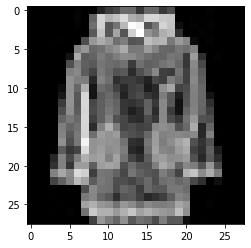

In [ ]:
#Pixel representation
import matplotlib.pyplot as plt

fig = plt.figure()

plt.imshow(example_data[0][0], cmap='gray', interpolation='none')





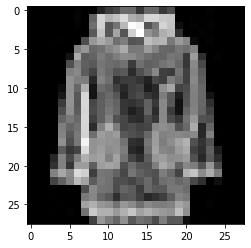

In [ ]:
#DCT representation

fig1 = plt.figure()

plt.imshow(dct.idct(dct.dct(example_data[0][0])), cmap='gray', interpolation='none')



In [ ]:
#MSE LOSS between the two tensors
input = example_data
target = dct.idct(dct.dct(example_data))
mse_loss = nn.MSELoss()
output = mse_loss(input, target)


#print('input: ', input)
#print('target: ', target)
print('output: ', output)

output:  tensor(2.4476e-15)
